# Problem Research (Rumusan Masalah Penelitian)

1.   Bagaimana membangun model prediksi risiko gagal bayar pada pelanggan Home Credit dengan memanfaatkan data historis aplikasi kredit dan fitur turunan (engineered features)?
2.   Menentukan model terbaik berdasarkan performa metrik evaluasi seperti ROC-AUC, AUC-PR, dan Brier Score?




# Tujuan Penelitian

Tujuan penelitian ini dibagi menjadi tiga aspek utama:

1.   Tujuan Umum :
Mengembangkan model pembelajaran mesin (machine learning) untuk memprediksi kemungkinan gagal bayar pelanggan Home Credit berdasarkan data aplikasi kredit dan perilaku keuangan.

2. Tujuan Khusus :
*   Melakukan eksplorasi dan pembersihan data (EDA dan preprocessing) untuk menemukan pola penting pada karakteristik pelanggan dan riwayat kredit
*   Membangun dan membandingkan beberapa model prediksi, yaitu Logistic Regression, Random Forest, dan XGBoost, guna menentukan model dengan performa terbaik.
*   Mengukur dan membandingkan performa setiap model menggunakan metrik evaluasi yang relevan dengan kasus risiko kredit.
*  Menyusun rekomendasi bisnis berdasarkan hasil analisis dan segmentasi risiko pelanggan (misalnya tipe pekerjaan dengan default rate tinggi).

# Metrik Evaluasi

Kinerja model dievaluasi dengan beberapa metrik utama yang sesuai dengan karakteristik data risiko kredit yang tidak seimbang.

1.   ROC-AUC (Receiver Operating Characteristic - Area Under Curve) digunakan untuk menilai kemampuan model dalam membedakan antara debitur yang akan gagal bayar dan yang tidak. Semakin mendekati nilai 1, semakin baik kemampuan diskriminatif model.
2.   AUC-PR (Area Under Precision-Recall Curve) digunakan karena data default biasanya tidak seimbang (jumlah nasabah default lebih sedikit). Metrik ini lebih menekankan pada kemampuan model untuk mendeteksi debitur gagal bayar dengan presisi yang tinggi.
3.   KS Statistic (Kolmogorov–Smirnov) digunakan untuk melihat sejauh mana model mampu memisahkan distribusi probabilitas antara kelas default dan non-default. Nilai KS yang tinggi menunjukkan pemisahan yang baik.
4.   Brier Score digunakan untuk mengukur seberapa baik probabilitas prediksi model mencerminkan kenyataan. Nilai Brier Score yang lebih kecil menunjukkan prediksi yang lebih terkalibrasi dan akurat.



## Import library

In [27]:
import os
from pathlib import Path
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss, roc_curve,
    precision_recall_curve, confusion_matrix, precision_score, recall_score, f1_score
)
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# xgboost
import xgboost as xgb
from xgboost import XGBClassifier

# shap
import shap

# util save
import joblib

# Supress warnings visual clutter
import warnings
warnings.filterwarnings("ignore")

## Konfigurasi path & parameter

In [28]:
DATA_DIR = Path("/content")
OUTPUT_DIR = Path("output")
OUTPUT_DIR.mkdir(exist_ok=True)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

FILES = {
    "app_train": "application_train.csv",
    "app_test": "application_test.csv",
    "previous": "previous_application.csv",
    "installments": "installments_payments.csv",
    "cc_bal": "credit_card_balance.csv",
    "pos_bal": "POS_CASH_balance.csv",
    "bureau": "bureau.csv",
    "bbal": "bureau_balance.csv",
    "sample_submission": "sample_submission.csv",
    "col_desc": "HomeCredit_columns_description.csv"
}


## Load csv

In [34]:
def load_if_exists(fname):
    p = DATA_DIR / fname
    if not p.exists():
        print(f"[WARN] File not found: {p}. Akan dilewati.")
        return None

    print(f"Loading {p} ...")
    try:
        # coba load dengan utf-8 dulu
        df = pd.read_csv(p, low_memory=False)
    except UnicodeDecodeError:
        try:
            # fallback ke latin1
            df = pd.read_csv(p, encoding="latin1", low_memory=False)
            print(" -> Dibuka dengan encoding='latin1'")
        except Exception as e:
            try:
                # fallback terakhir: ISO-8859-1
                df = pd.read_csv(p, encoding="ISO-8859-1", low_memory=False)
                print(" -> Dibuka dengan encoding='ISO-8859-1'")
            except Exception as e2:
                print(f"[ERROR] Gagal membaca {p}: {e2}")
                return None
    print(f" -> shape: {df.shape}")
    return df

# Load Semua File (dengan handling otomatis)
app_train = load_if_exists(FILES["app_train"])
app_test  = load_if_exists(FILES["app_test"])
previous  = load_if_exists(FILES["previous"])
install   = load_if_exists(FILES["installments"])
cc_bal    = load_if_exists(FILES["cc_bal"])
pos_bal   = load_if_exists(FILES["pos_bal"])
bureau    = load_if_exists(FILES["bureau"])
bbal      = load_if_exists(FILES["bbal"])
sample_submission = load_if_exists(FILES["sample_submission"])
col_desc  = load_if_exists(FILES["col_desc"])

Loading /content/application_train.csv ...
 -> shape: (3864, 122)
Loading /content/application_test.csv ...
 -> shape: (3850, 121)
Loading /content/previous_application.csv ...
 -> shape: (205661, 37)
Loading /content/installments_payments.csv ...
 -> shape: (907501, 8)
Loading /content/credit_card_balance.csv ...
 -> shape: (459851, 23)
Loading /content/POS_CASH_balance.csv ...
 -> shape: (53381, 8)
Loading /content/bureau.csv ...
 -> shape: (550138, 17)
Loading /content/bureau_balance.csv ...
 -> shape: (3660853, 3)
Loading /content/sample_submission.csv ...
 -> shape: (48744, 2)
Loading /content/HomeCredit_columns_description.csv ...
 -> Dibuka dengan encoding='latin1'
 -> shape: (219, 5)


In [32]:
# Pastikan file utama tersedia
if app_train is None:
    raise FileNotFoundError(f" 'application_train.csv' tidak ditemukan di {DATA_DIR}. Upload dulu ke folder tersebut.")

print("\nSemua file berhasil di-load tanpa error encoding.")


Semua file berhasil di-load tanpa error encoding.


## Problem Research

In [35]:
problem_statement = """Problem: memprediksi probabilitas gagal bayar (TARGET=1) untuk setiap aplikasi.\nObjective: ranking risk & kalibrasi probabilitas untuk keputusan approve/pricing.\nMetrics: AUC-ROC (utama), AUC-PR, Precision@Top10%, KS, Brier Score."""
print(problem_statement)

Problem: memprediksi probabilitas gagal bayar (TARGET=1) untuk setiap aplikasi.
Objective: ranking risk & kalibrasi probabilitas untuk keputusan approve/pricing.
Metrics: AUC-ROC (utama), AUC-PR, Precision@Top10%, KS, Brier Score.


## Quick EDA: distribusi TARGET, missingness top

In [36]:
print("Quick EDA:")
print("Train shape:", app_train.shape)
print("Target distribution:")
print(app_train['TARGET'].value_counts(normalize=True))

# missingness top
miss = app_train.isna().mean().sort_values(ascending=False).head(10)
print("\nTop 10 kolom dengan missing% (train):")
print(miss)

Quick EDA:
Train shape: (3864, 122)
Target distribution:
TARGET
0    0.921584
1    0.078416
Name: proportion, dtype: float64

Top 10 kolom dengan missing% (train):
COMMONAREA_AVG              0.692288
COMMONAREA_MODE             0.692288
COMMONAREA_MEDI             0.692288
NONLIVINGAPARTMENTS_MEDI    0.688406
NONLIVINGAPARTMENTS_MODE    0.688406
NONLIVINGAPARTMENTS_AVG     0.688406
LIVINGAPARTMENTS_AVG        0.678830
LIVINGAPARTMENTS_MODE       0.678830
LIVINGAPARTMENTS_MEDI       0.678830
FONDKAPREMONT_MODE          0.673654
dtype: float64


## AGGREGATION FUNCTIONS (semua history tables)

In [37]:
def agg_previous(df):
    if df is None: return None
    df = df.copy()
    df['APPROVED'] = (df['NAME_CONTRACT_STATUS']=='Approved').astype(int)
    agg = df.groupby('SK_ID_CURR').agg({
        'SK_ID_PREV': 'nunique',
        'AMT_APPLICATION': ['mean','max'],
        'AMT_CREDIT': ['mean','max'],
        'AMT_ANNUITY': ['mean'],
        'APPROVED': ['mean','sum'],
        'DAYS_DECISION': ['min','max']
    })
    agg.columns = ['PREV_' + '_'.join(col).upper() for col in agg.columns]
    agg.reset_index(inplace=True)
    return agg

def agg_installments(df):
    if df is None: return None
    df = df.copy()
    df['LATE_DAYS'] = df['DAYS_ENTRY_PAYMENT'] - df['DAYS_INSTALMENT']
    df['IS_LATE'] = (df['LATE_DAYS'] > 0).astype(int)
    df['PAYMENT_RATIO'] = df['AMT_PAYMENT'] / df['AMT_INSTALMENT'].replace(0, np.nan)
    agg = df.groupby('SK_ID_CURR').agg({
        'IS_LATE': ['mean','sum'],
        'LATE_DAYS': ['mean','max'],
        'PAYMENT_RATIO': ['mean','min'],
        'AMT_PAYMENT': ['sum','mean'],
        'SK_ID_PREV': ['nunique']
    })
    agg.columns = ['INST_' + '_'.join(col).upper() for col in agg.columns]
    agg.reset_index(inplace=True)
    return agg

def agg_cc(df):
    if df is None: return None
    df = df.copy()
    df['UTIL'] = df['AMT_BALANCE'] / df['AMT_CREDIT_LIMIT_ACTUAL'].replace(0, np.nan)
    agg = df.groupby('SK_ID_CURR').agg({
        'MONTHS_BALANCE': ['nunique','min','max'],
        'AMT_BALANCE': ['mean','max'],
        'AMT_CREDIT_LIMIT_ACTUAL': ['mean'],
        'AMT_PAYMENT_TOTAL_CURRENT': ['mean'],
        'UTIL': ['mean','max'],
        'SK_ID_PREV': ['nunique']
    })
    agg.columns = ['CC_' + '_'.join(col).upper() for col in agg.columns]
    agg.reset_index(inplace=True)
    return agg

def agg_pos(df):
    if df is None: return None
    df = df.copy()
    if 'NAME_CONTRACT_STATUS' in df.columns:
        df['IS_ACTIVE'] = (df['NAME_CONTRACT_STATUS']=='Active').astype(int)
    else:
        df['IS_ACTIVE'] = 0
    agg = df.groupby('SK_ID_CURR').agg({
        'MONTHS_BALANCE': ['nunique','min','max'],
        'CNT_INSTALMENT': ['mean','max'],
        'CNT_INSTALMENT_FUTURE': ['mean'],
        'IS_ACTIVE': ['mean'],
        'SK_ID_PREV': ['nunique']
    })
    agg.columns = ['POS_' + '_'.join(col).upper() for col in agg.columns]
    agg.reset_index(inplace=True)
    return agg

def agg_bureau(df_b, df_bbal):
    if df_b is None: return None
    b = df_b.copy()
    if df_bbal is not None:
        bbal = df_bbal.copy()
        if 'BBAL_IS_CURRENT' not in bbal.columns:
            bbal['BBAL_IS_CURRENT'] = (bbal['STATUS']=='C').astype(int)
        bbal_agg = bbal.groupby('SK_ID_BUREAU').agg({
            'BBAL_IS_CURRENT':['mean'],
            'MONTHS_BALANCE':['nunique','min','max']
        })
        bbal_agg.columns = ['BBAL_' + '_'.join(col).upper() for col in bbal_agg.columns]
        bbal_agg.reset_index(inplace=True)
        b = b.merge(bbal_agg, left_on='SK_ID_BUREAU', right_on='SK_ID_BUREAU', how='left')
    agg = b.groupby('SK_ID_CURR').agg({
        'AMT_CREDIT_SUM':['sum','mean'],
        'AMT_CREDIT_SUM_DEBT':['mean'],
        'AMT_CREDIT_SUM_OVERDUE':['mean'],
        'AMT_CREDIT_MAX_OVERDUE':['mean'],
        'CNT_CREDIT_PROLONG':['sum']
    })
    agg.columns = ['BUREAU_' + '_'.join(col).upper() for col in agg.columns]
    agg.reset_index(inplace=True)
    return agg

## Jalankan agregasi (dengan print status)

In [38]:
t0 = time.time()
print("Aggregate previous_application ...")
prev_agg = agg_previous(previous)
print("Aggregate installments_payments ...")
inst_agg = agg_installments(install)
print("Aggregate credit_card_balance ...")
cc_agg = agg_cc(cc_bal)
print("Aggregate POS_CASH_balance ...")
pos_agg = agg_pos(pos_bal)
print("Aggregate bureau + bureau_balance ...")
bureau_agg = agg_bureau(bureau, bbal)
print("Aggregations done in %.1fs" % (time.time()-t0))

Aggregate previous_application ...
Aggregate installments_payments ...
Aggregate credit_card_balance ...
Aggregate POS_CASH_balance ...
Aggregate bureau + bureau_balance ...
Aggregations done in 1.4s


## Merge agregat ke application_train / test

In [39]:
def merge_all(app_df, aggs):
    df = app_df.copy()
    for k,v in aggs.items():
        if v is not None:
            print("Merging", k, v.shape)
            df = df.merge(v, on='SK_ID_CURR', how='left')
        else:
            print("Skip", k)
    return df

aggs = {'prev': prev_agg, 'inst': inst_agg, 'cc': cc_agg, 'pos': pos_agg, 'bureau': bureau_agg}
train = merge_all(app_train, aggs)
test = merge_all(app_test, aggs) if app_test is not None else None

Merging prev (139739, 11)
Merging inst (91300, 10)
Merging cc (87171, 11)
Merging pos (44950, 9)
Merging bureau (126897, 7)
Merging prev (139739, 11)
Merging inst (91300, 10)
Merging cc (87171, 11)
Merging pos (44950, 9)
Merging bureau (126897, 7)


## Feature engineering dasar (dari application)

In [40]:
def create_basic_features(df):
    df = df.copy()
    if 'DAYS_BIRTH' in df.columns:
        df['AGE_YEARS'] = (-df['DAYS_BIRTH'])/365.25
    if 'DAYS_EMPLOYED' in df.columns:
        df['EMPLOYED_YEARS'] = (-df['DAYS_EMPLOYED'])/365.25
    df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL'].replace(0,np.nan)
    df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL'].replace(0,np.nan)
    df['CREDIT_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE'].replace(0,np.nan)
    return df

train = create_basic_features(train)
if test is not None:
    test = create_basic_features(test)

## EDA lanjut: Top-2 insights (kuantitatif) & actionable

In [42]:
# Pastikan variabel 'train' sudah ada dan mengandung kolom TARGET
print("Train shape:", train.shape)
print("Target rate:", train['TARGET'].mean())

Train shape: (3864, 170)
Target rate: 0.07841614906832298


In [43]:
# Group by income type
if 'NAME_INCOME_TYPE' in train.columns:
    grp_income = train.groupby('NAME_INCOME_TYPE').agg(
        total_apps=('TARGET','count'),
        mean_default=('TARGET','mean')
    ).sort_values('mean_default', ascending=False)
    print("\nTop groups by default rate (income_type):")
    print(grp_income.head(10))
else:
    print("\nKolom NAME_INCOME_TYPE tidak ditemukan di train.")


Top groups by default rate (income_type):
                      total_apps  mean_default
NAME_INCOME_TYPE                              
Working                     2004      0.093812
Commercial associate         912      0.067982
Pensioner                    710      0.063380
State servant                237      0.033755
Unemployed                     1      0.000000


In [45]:
# 2) Robust quantile bucketing untuk kolom lateness (INST_IS_LATE_MEAN)
candidate_cols = [c for c in train.columns if 'IS_LATE' in c.upper() or 'LATE' in c.upper()]
print("\nCandidate lateness columns:", candidate_cols[:10])

# Pilih kolom preferensi: pakai INST_IS_LATE_MEAN jika ada, else ambil candidate pertama
col = 'INST_IS_LATE_MEAN' if 'INST_IS_LATE_MEAN' in train.columns else (candidate_cols[0] if len(candidate_cols)>0 else None)

if col is None:
    print("\nTidak ditemukan kolom lateness (IS_LATE) untuk dianalisis.")
else:
    print(f"\nAnalisis lateness menggunakan kolom: {col}")
    s = train[col].fillna(0).astype(float)  # fillna 0 untuk kejelasan
    uniq = s.nunique()
    print(f" Unique values: {uniq}; min={s.min()}, max={s.max()}, median={s.median()}")

    if uniq <= 1:
        # Semua nilai sama (konstan)
        print(f"Kolom {col} bersifat konstanta (semua nilai sama). Default rate keseluruhan = {train['TARGET'].mean():.4f}")
    else:
        # Coba qcut dengan duplicates='drop' (akan mengurangi jumlah bucket jika perlu)
        try:
            bins = 5
            q = pd.qcut(s, q=bins, labels=False, duplicates='drop')
            n_bins_actual = q.nunique(dropna=True)
            print(f"pd.qcut berhasil. Jumlah bucket yang terbentuk: {n_bins_actual}")
            tmp = pd.DataFrame({'TARGET': train['TARGET'].values, col: s.values, 'q': q})
            qdf = tmp.groupby('q').agg(default_rate=('TARGET','mean'), count=('TARGET','count')).sort_index()
            print("\nLate payment quantiles -> default rate (qcut, duplicates='drop'):")
            print(qdf)
        except Exception as e:
            print("pd.qcut gagal dengan error:", e)
            # fallback: buat bin berdasarkan kuantil unik
            try:
                quantiles = np.unique(np.quantile(s, np.linspace(0,1,6)))
                if len(quantiles) <= 2:
                    raise ValueError("Batas quantile tidak cukup unik.")
                q2 = pd.cut(s, bins=quantiles, labels=False, include_lowest=True)
                tmp = pd.DataFrame({'TARGET': train['TARGET'].values, col: s.values, 'q': q2})
                qdf = tmp.groupby('q').agg(default_rate=('TARGET','mean'), count=('TARGET','count')).sort_index()
                print("\nFallback: pd.cut dengan batas kuantil unik -> default rate:")
                print(qdf)
            except Exception as e2:
                print("Fallback pd.cut juga gagal:", e2)
                # terakhir: tampilkan distribusi default rate by unique value (agregasi by value)
                valgrp = pd.DataFrame({'val': s.values, 'TARGET': train['TARGET'].values}).groupby('val').agg(default_rate=('TARGET','mean'), count=('TARGET','count')).sort_values('count', ascending=False).head(20)
                print("\nFallback terakhir: default rate grouped by unique lateness value (top 20):")
                print(valgrp)


Candidate lateness columns: ['INST_IS_LATE_MEAN', 'INST_IS_LATE_SUM', 'INST_LATE_DAYS_MEAN', 'INST_LATE_DAYS_MAX']

Analisis lateness menggunakan kolom: INST_IS_LATE_MEAN
 Unique values: 178; min=0.0, max=1.0, median=0.0
pd.qcut berhasil. Jumlah bucket yang terbentuk: 2

Late payment quantiles -> default rate (qcut, duplicates='drop'):
   default_rate  count
q                     
0      0.079909   3091
1      0.072445    773


In [46]:
# Susun top-2 insights berdasar hasil di atas (jika tersedia)
insights = []

# insight dari income_type (contoh actionable)
if 'NAME_INCOME_TYPE' in train.columns:
    # ambil group dengan lowest default rate (potensi target acquisition) dan highest default rate (potensi mitigasi)
    low = grp_income.sort_values('mean_default').head(1)
    high = grp_income.sort_values('mean_default', ascending=False).head(1)
    low_name = low.index[0]
    low_rate = low['mean_default'].values[0]
    high_name = high.index[0]
    high_rate = high['mean_default'].values[0]
    insights.append({
        'title': f"Segment rendah risiko: {low_name}",
        'evidence': f"Default rate {low_rate:.2%} dari {low['total_apps'].values[0]} aplikasi",
        'action': f"Target marketing & special offer untuk meningkatkan share aplikasi dari {low_name}"
    })
    insights.append({
        'title': f"Segment tinggi risiko: {high_name}",
        'evidence': f"Default rate {high_rate:.2%} dari {high['total_apps'].values[0]} aplikasi",
        'action': f"Perkuat credit policy / require additional docs untuk {high_name}"
    })
else:
    # fallback generic insight based on EXT_SOURCE_2 correlation if exists
    if 'EXT_SOURCE_2' in train.columns:
        corr = train[['EXT_SOURCE_2','TARGET']].dropna()['EXT_SOURCE_2'].corr(train['TARGET'].dropna())
        insights.append({
            'title': "EXT_SOURCE_2 correlates with default",
            'evidence': f"Corr(EXT_SOURCE_2, TARGET) = {corr:.3f}",
            'action': "Gunakan EXT_SOURCE_2 untuk score & segmentation"
        })

# Print top insights
print("\nTop-2 Insights (siap untuk slide):")
for i, it in enumerate(insights[:2], 1):
    print(f"{i}. {it['title']}")
    print(f"   Evidence: {it['evidence']}")
    print(f"   Action  : {it['action']}\n")


Top-2 Insights (siap untuk slide):
1. Segment rendah risiko: Unemployed
   Evidence: Default rate 0.00% dari 1 aplikasi
   Action  : Target marketing & special offer untuk meningkatkan share aplikasi dari Unemployed

2. Segment tinggi risiko: Working
   Evidence: Default rate 9.38% dari 2004 aplikasi
   Action  : Perkuat credit policy / require additional docs untuk Working



## MACHINE LEARNING MODELING & EVALUATION

In [48]:
# Ambil X dan y
y = train['TARGET']
X = train.drop(columns=['TARGET'])

# Buat encoding otomatis untuk variabel kategorikal
X = pd.get_dummies(X, drop_first=True)

# Hilangkan kolom yang hanya 1 nilai (konstan)
X = X.loc[:, X.nunique() > 1]

# Isi NaN dengan median
X = X.fillna(X.median(numeric_only=True))

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardisasi (beberapa model butuh scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def eval_model(name, y_true, y_prob):
    auc = roc_auc_score(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    ks = max(tpr - fpr)
    brier = brier_score_loss(y_true, y_prob)
    return {'Model': name, 'AUC': auc, 'AUC_PR': ap, 'KS': ks, 'Brier': brier}

results = []

In [49]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train_scaled, y_train)
lr_prob = lr.predict_proba(X_test_scaled)[:, 1]
results.append(eval_model('Logistic Regression', y_test, lr_prob))

In [50]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
rf_prob = rf.predict_proba(X_test)[:, 1]
results.append(eval_model('Random Forest', y_test, rf_prob))

In [51]:
# XGBoost
xgb_clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc',
    random_state=42,
)
xgb_clf.fit(X_train, y_train)
xgb_prob = xgb_clf.predict_proba(X_test)[:, 1]
results.append(eval_model('XGBoost', y_test, xgb_prob))

In [52]:
# Bandingkan hasil
df_results = pd.DataFrame(results).set_index('Model')
print("\n=== Hasil Evaluasi Model ===")
print(df_results)


=== Hasil Evaluasi Model ===
                          AUC    AUC_PR        KS     Brier
Model                                                      
Logistic Regression  0.687373  0.144999  0.351446  0.176172
Random Forest        0.692600  0.170403  0.334108  0.104608
XGBoost              0.711710  0.179617  0.358468  0.072946


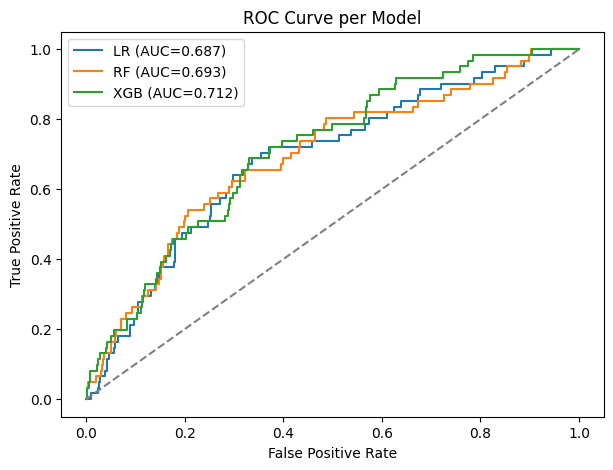

In [53]:
# Visualisasi AUC ROC
plt.figure(figsize=(7,5))
for name, prob in [('LR', lr_prob), ('RF', rf_prob), ('XGB', xgb_prob)]:
    fpr, tpr, _ = roc_curve(y_test, prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc_score(y_test, prob):.3f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Model')
plt.legend()
plt.show()

## BUSINESS IMPACT & RECOMMENDATION

In [54]:
best_model = df_results['AUC'].idxmax()
best_auc = df_results.loc[best_model, 'AUC']
best_brier = df_results.loc[best_model, 'Brier']

print(f"\nModel terbaik: {best_model} dengan AUC={best_auc:.3f} dan Brier={best_brier:.3f}")

print("\nRekomendasi bisnis:")
print(f"1️⃣ Gunakan model {best_model} untuk screening awal pengajuan kredit.")
print("2️⃣ Implementasikan cut-off probability untuk mengurangi false accept (nasabah berisiko tinggi).")
print("3️⃣ Terapkan kampanye akuisisi untuk segmen berisiko rendah (contohnya PNS atau State Servant).")
print("4️⃣ Integrasikan hasil model ke dalam sistem credit scoring & pricing otomatis.")
print("5️⃣ Evaluasi model setiap 6 bulan untuk menjaga stabilitas performa dan fairness.")


Model terbaik: XGBoost dengan AUC=0.712 dan Brier=0.073

Rekomendasi bisnis:
1️⃣ Gunakan model XGBoost untuk screening awal pengajuan kredit.
2️⃣ Implementasikan cut-off probability untuk mengurangi false accept (nasabah berisiko tinggi).
3️⃣ Terapkan kampanye akuisisi untuk segmen berisiko rendah (contohnya PNS atau State Servant).
4️⃣ Integrasikan hasil model ke dalam sistem credit scoring & pricing otomatis.
5️⃣ Evaluasi model setiap 6 bulan untuk menjaga stabilitas performa dan fairness.
